In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import wandb

In [22]:
train_df = pd.read_csv("/content/Tulu-SA-train.csv")
val_df = pd.read_csv("/content/Tulu-SA-val.csv")

train_df.dropna( inplace=True)
val_df.dropna(inplace=True)

train_df = train_df[train_df['Label'] != 'unknown_state']
val_df = val_df[val_df['Label'] != 'unknown_state']

In [23]:
label_map = {
    'Not Tulu': 0,
    'Positive': 1,
    'Neutral': 2,
    'Mixed': 3,
    'Negative': 4,
}

train_df['numeric_label'] = train_df['Label'].map(label_map)
val_df['numeric_label'] = val_df['Label'].map(label_map)

print(f"Number of training examples: {len(train_df)}")
print(f"Number of validation examples: {len(val_df)}")

Number of training examples: 13306
Number of validation examples: 1642


In [24]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_map),
    problem_type="single_label_classification",
    ignore_mismatched_sizes=True
)


In [25]:
train_dataset = SentimentDataset(
    train_df['Text'].values,
    train_df['numeric_label'].values,
    tokenizer
)
val_dataset = SentimentDataset(
    val_df['Text'].values,
    val_df['numeric_label'].values,
    tokenizer
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [10]:
batch_size = 16 if torch.cuda.is_available() else 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [11]:
# Move model to device
model = model.to(device)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_training_steps // 10,
    num_training_steps=num_training_steps
)

In [12]:
# Training function
def train_model():
    best_val_f1 = 0
    patience = 3
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')

        model.train()
        total_train_loss = 0
        train_predictions = []
        train_labels = []

        for batch in tqdm(train_loader, desc='Training'):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            predictions = torch.argmax(outputs.logits, dim=-1)
            train_predictions.extend(predictions.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        avg_train_loss = total_train_loss / len(train_loader)
        train_f1 = f1_score(train_labels, train_predictions, average='weighted')

        model.eval()
        total_val_loss = 0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validating'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                total_val_loss += loss.item()

                predictions = torch.argmax(outputs.logits, dim=-1)
                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_f1 = f1_score(val_labels, val_predictions, average='weighted')

        print(f'Training Loss: {avg_train_loss:.3f}, Training F1: {train_f1:.3f}')
        print(f'Validation Loss: {avg_val_loss:.3f}, Validation F1: {val_f1:.3f}')

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0

            model_save_path = f'best_model_f1_{val_f1:.3f}'
            model.save_pretrained(model_save_path)
            tokenizer.save_pretrained(model_save_path)
            print(f'Saved best model with F1: {val_f1:.3f}')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break

In [27]:
def predict_sentiment(text, model, tokenizer, label_map):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=128,
        padding=True
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1)

    reverse_label_map = {v: k for k, v in label_map.items()}
    return reverse_label_map[prediction.item()]

In [ ]:
train_model()

In [28]:
def load_best_model(model_path):
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer

In [30]:
text = 'ಮಾತ ಮನುಷ್ಯೆರ್ ಸ್ವತಂತ್ರೆರಾದ್ ಪುಟ್ಟುವೆರ್. ಅಂಚನೆ ಮರ್ಯಾದಿ ಬೊಕ್ಕ ಹಕ್ಕುಡು ಸಮಾನವಾದುಪ್ಪುವೆರ್. ಗೇನ ಬೊಕ್ಕ ವಿವೀಕೊನ್ ಪಡೆದಿನ ಮನುಷ್ಯೆರ್ ಅಕುಲಕುಲು ಸಹೋದರ ಭಾವನೆಡ್ ನಡಪೊಡು.'
model, tokenizer = load_best_model('/content/Tulu_model')  # Load your pre-trained model
sentiment = predict_sentiment(text, model, tokenizer, label_map)  # Get prediction
print(f"Predicted sentiment: {sentiment}")

Predicted sentiment: Mixed


In [31]:
y_pred = []
for i in range(len(val_df)):
    sentiment = predict_sentiment(val_df.Text.iloc[i], model, tokenizer, label_map)  # Get prediction
    y_pred.append(sentiment)

In [32]:
y_pred = np.array(y_pred)
y_true = np.array(val_df.Label)

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       Mixed       0.34      0.25      0.29       143
    Negative       0.47      0.40      0.43       118
     Neutral       0.63      0.67      0.65       368
    Not Tulu       0.87      0.89      0.88       543
    Positive       0.75      0.78      0.76       470

    accuracy                           0.72      1642
   macro avg       0.61      0.60      0.60      1642
weighted avg       0.71      0.72      0.71      1642



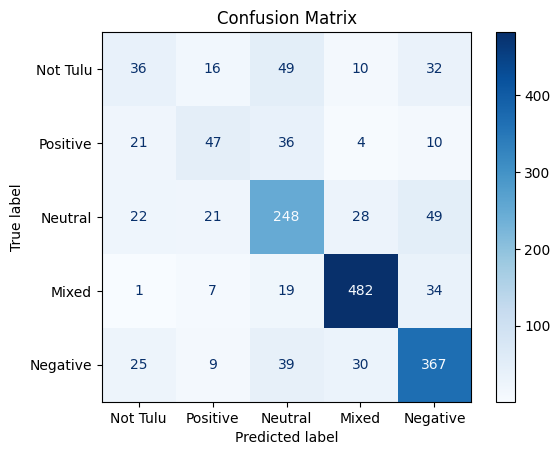

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()